# Overview
Compare inference using a Bayesian Gaussian process with reference prior to a Gaussian process using maximum likelihood on a simple example data set

## Import Dependencies

In [1]:
import numpy as np
import scipy
from bbai.gp import BayesianGaussianProcessRegression, RbfCovarianceFunction
import matplotlib.pyplot as plt

np.random.seed(0)

## Generate Data Set

In [2]:
def make_location_matrix(N):
    res = np.zeros((N, 1))
    step = 1.0 / (N - 1)
    for i in range(N):
        res[i, 0] = i * step
    return res

In [3]:
def make_covariance_matrix(S, sigma2, theta, eta):
    N = len(S)
    res = np.zeros((N, N))
    for i in range(N):
        si = S[i]
        for j in range(N):
            sj = S[j]
            d = np.linalg.norm(si - sj)
            res[i, j] = np.exp(-0.5*(d/theta)**2)
        res[i, i] += eta
    return sigma2 * res

In [4]:
def make_target_vector(K):
    return np.random.multivariate_normal(np.zeros(K.shape[0]), K)

In [5]:
np.random.seed(2)
N = 20
sigma2 = 25
theta = 0.01
eta = 0.1
params = (sigma2, theta, eta)
S = make_location_matrix(N)
K = make_covariance_matrix(S, sigma2, theta, eta)
y = make_target_vector(K)

## Likelihood computations

In [6]:
def compute_log_likelihood(y, S, params):
    sigma2, theta, eta = params
    K = make_covariance_matrix(S, sigma2, theta, eta)
    L = np.linalg.cholesky(K)
    term1 = -np.sum(np.log(np.diagonal(L)))
    t = scipy.linalg.solve_triangular(L, y, lower=True)
    term2 = -0.5 * np.dot(t, t)
    return term1 + term2

## Prediction

In [7]:
def compute_prediction_var(params, sp):
    sigma2, theta, eta = params
    num_train = len(S)
    num_test = 1
    n = num_train + num_test
    S_star = np.vstack((S, [sp]))
    K_star = make_covariance_matrix(S_star, sigma2, theta, eta)
    K11 = K_star[:num_train, :num_train]
    K21 = K_star[num_train:, :num_train]
    K22 = K_star[num_train:, num_train:]
    Kp = K22 - np.dot(K21, np.dot(np.linalg.inv(K11), K21.T))
    return Kp[0, 0]

In [8]:
def compute_prediction_mean(params, sp):
    sigma2, theta, eta = params
    num_train = len(S)
    num_test = 1
    n = num_train + num_test
    S_star = np.vstack((S, [sp]))
    K_star = make_covariance_matrix(S_star, sigma2, theta, eta)
    K11 = K_star[:num_train, :num_train]
    K21 = K_star[num_train:, :num_train]
    K22 = K_star[num_train:, num_train:]
    Kp = K22 - np.dot(K21, np.dot(np.linalg.inv(K11), K21.T))
    t = np.dot(np.linalg.inv(K11), y)
    return np.dot(K21, t)[0]

## Fit a ML Model

In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

kernel = sigma2 * RBF(length_scale=theta) + WhiteKernel(noise_level=sigma2*eta)
model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, random_state=0)
model.fit(S, y)
print(model.kernel_)
np.exp(model.kernel_.theta)
sigma2_ML, length_ML, noise_ratio_ML = np.exp(model.kernel_.theta)
noise_ratio_ML /= sigma2_ML
params_ML = (sigma2_ML, length_ML, noise_ratio_ML)
print('sigma2', sigma2_ML)
print('length', length_ML)
print('noise_ratio', noise_ratio_ML)

5.87**2 * RBF(length_scale=0.0354) + WhiteKernel(noise_level=0.00113)
sigma2 34.42135587259495
length 0.03535253249783556
noise_ratio 3.293935450837371e-05


In [10]:
ll_true = compute_log_likelihood(y, S, params)
ll_ML = compute_log_likelihood(y, S, params_ML)
print(ll_true, ll_ML)
print(np.exp(ll_ML - ll_true))

-45.39235670795158 -44.17120936058904
3.3910762448439056


In [11]:
var_true = compute_prediction_var(params, [0.1])
std_true = var_true**.5
mean_true = compute_prediction_mean(params, [0.1])
print(mean_true, var_true**.5)

5.843437159509895 3.204938668837829


In [12]:
mean_ML, std_ML = model.predict([[0.1]], return_std=True)
mean_ML = mean_ML[0]
std_ML = std_ML[0]
print(mean_ML, std_ML)

6.474386419367033 0.5921919578979292


In [13]:
pdf_true = scipy.stats.norm(loc=mean_true, scale=std_true)
pdf_ML = scipy.stats.norm(loc=mean_ML, scale=std_ML)

Text(0, 0.5, 'Density')

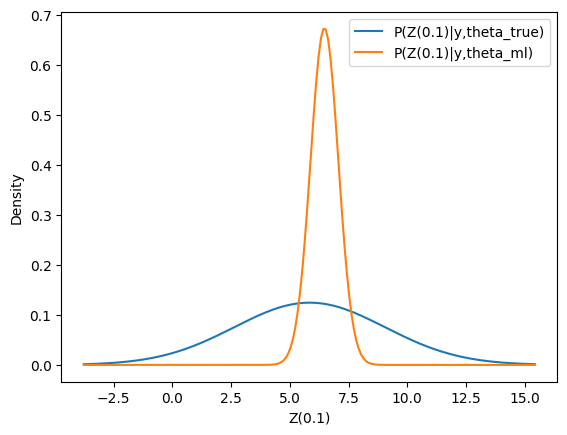

In [14]:
xs = np.arange(mean_true-3*std_true, mean_true+3*std_true, 0.1)
ys_true = [pdf_true.pdf(yi) for yi in xs]
ys_ml = [pdf_ML.pdf(yi) for yi in xs]
plt.plot(xs, ys_true, label='P(Z(0.1)|y,theta_true)')
plt.plot(xs, ys_ml, label='P(Z(0.1)|y,theta_ml)')
plt.legend()
plt.xlabel('Z(0.1)')
plt.ylabel('Density')

## Fit Model

In [15]:
model = BayesianGaussianProcessRegression(kernel=RbfCovarianceFunction())
model.fit(S, y)

In [16]:
_, pdf = model.predict([[0.1]], with_pdf=True)
pdf_bay = pdf[0]

Text(0, 0.5, 'Density')

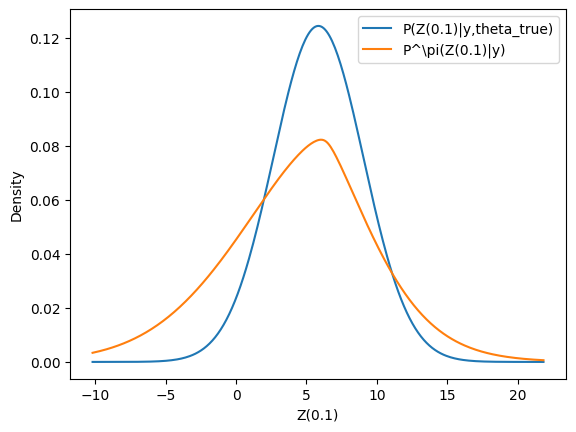

In [17]:
xs = np.arange(mean_true-5*std_true, mean_true+5*std_true, 0.1)
ys_true = [pdf_true.pdf(yi) for yi in xs]
ys_bay = [pdf_bay.pdf(yi) for yi in xs]
plt.plot(xs, ys_true, label='P(Z(0.1)|y,theta_true)')
plt.plot(xs, ys_bay, label='P^\pi(Z(0.1)|y)')
plt.legend()
plt.xlabel('Z(0.1)')
plt.ylabel('Density')